### Imports

In [181]:
from sklearn.datasets import fetch_mldata
import numpy as np
from sklearn.linear_model import SGDClassifier

# cross-validation
from sklearn.model_selection import cross_val_score, cross_val_predict

In [10]:
# Getting the data 
mnist = fetch_mldata('MNIST original')

/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [75]:
# Getting dataset info
print(mnist)

# Split into data and labels
X, y = mnist['data'], mnist['target']

print(X.shape)
print(y.shape)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
(70000, 784)
(70000,)
6313


2.0


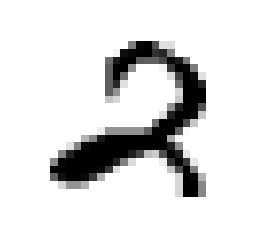

In [42]:
# Showing a sample of the dataset
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import random

random_int = random.randint(0, X.shape[0])

random_number = X[random_int].reshape(28, 28)
plt.imshow(random_number, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show

print(y[random_int]

### Data prep

In [76]:
# shuffling the data 

shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

In [77]:
# 6000/1000 train test split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Developing as 5 identifier

Using a stochastic gradient descent model, we're going to build a model thatwill try to determine if an image is representing a number five.

In [78]:
# Creating a boolean mask for 5 and non-5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [79]:
# Training the SGD Classification model

sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

It's some other number...


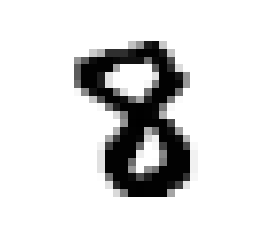

In [180]:
rand = random.randint(0, 10000)
X_example = X_test[rand]
y_example = y_test[rand]

%matplotlib inline

plt.imshow(X_example.reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')

if sgd_class.predict([X_example])[0]:
    print('It\'s a five!')
else:
    print('It\'s some other number...')

### Measuring the accuracy of the model

In [ ]:
# Using cross-validation

cross_val_score(sgd_class, )